# CYCLOPS on 12 Tissue Data (Boxplots - consistency)

## 1. Importing packages

In [1]:
from cyclops_v2 import *
from spca import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Loading data

In [2]:
df = pd.read_csv("circadian_12tissue_data.csv").T

#### Choose the tissue to investigate:

In [3]:
tissue = 'Lun'

#### Print gene expression dataframe:

In [4]:
df = df[df.index.str.contains(tissue)]
df.head()

,0,1,2,3,4,5,6,7,8,9,...,23033,23034,23035,23036,23037,23038,23039,23040,23041,23042
Lun_CT18,9.4866,4.06621,6.18583,5.7147,4.7185,5.45873,8.02932,11.0936,10.1745,8.73325,...,4.41519,5.66148,10.2089,4.54611,4.6117,6.42419,4.56419,4.93813,4.31981,6.16044
Lun_CT20,9.6445,4.0441,6.14134,5.65521,4.65929,4.959,8.10229,11.0446,10.2021,8.69661,...,4.29994,5.66239,10.1943,4.52654,4.72125,6.28411,4.57532,4.8639,4.36117,6.08547
Lun_CT22,9.57623,4.10866,6.14849,5.7224,4.74965,5.02091,8.15491,11.0688,10.0014,8.64346,...,4.42678,5.59889,10.2062,4.58558,4.70504,6.77365,4.50431,4.90698,4.39452,6.11717
Lun_CT24,9.51914,4.04951,6.15671,5.89517,4.6641,4.99123,8.04472,10.9812,10.0651,8.70933,...,4.32225,5.60704,10.3452,4.5786,4.71754,6.30652,4.53244,4.94255,4.32257,6.09967
Lun_CT26,9.38881,4.03432,6.12423,5.67039,4.5516,6.22432,7.95547,10.8561,10.1025,8.71967,...,4.26943,5.56626,10.2225,4.47993,4.60318,6.21796,4.40968,4.96615,4.51338,5.95915


In [5]:
ng = df.shape[1]
nc = df.shape[0]
print("Running on {} genes and {} cells.".format(ng,nc))

Running on 23043 genes and 24 cells.


## 3. Data Preprocessing

Filter and sort genes in descending order of variance:

In [6]:
frac = 1.00

df_std = pd.DataFrame(df.std().sort_values(ascending=False))
df_std = df_std.iloc[:round(df_std.shape[0]*frac),:]
df_std.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23043 entries, 7070 to 20662
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       23043 non-null  float64
dtypes: float64(1)
memory usage: 360.0 KB


In [7]:
gene_list = df_std.index.to_numpy()
gene_list;

In [8]:
data = df.to_numpy().T

newdata = np.zeros([len(gene_list),nc])
for i in range(len(gene_list)):
    newdata[i] = data[gene_list[i]]
newdata = pd.DataFrame(newdata.T)
newdata.shape

(24, 23043)

Before performing dimensionality reduction, the dataset has to be __centered__ to zero mean:

In [9]:
df_cent = newdata.transform(lambda x: x-x.mean())
df_cent.head()

,0,1,2,3,4,5,6,7,8,9,...,23033,23034,23035,23036,23037,23038,23039,23040,23041,23042
0,1.902687,-2.140819,-1.004178,1.691643,0.302505,-1.131135,-0.661022,1.558409,-0.668365,1.269460,...,-0.016316,-0.004488,-0.001297,0.009906,-0.000084,-0.010038,-0.009995,0.010626,-0.004378,-0.020690
1,-1.467787,-3.072828,-1.621550,-1.093000,1.532809,1.059200,0.264971,-0.867065,-0.860352,-0.884719,...,0.033079,0.031947,-0.008875,0.026127,-0.023354,0.032352,0.013118,-0.008751,0.008034,-0.002725
2,-1.057831,-1.635855,-1.959684,-1.239721,1.786908,1.007027,-0.833995,-0.723251,-0.664188,-0.777693,...,0.017899,-0.010034,-0.015152,-0.016713,0.009167,-0.001855,0.018149,-0.011518,-0.019942,0.000991
3,-2.635650,-0.565418,-1.933030,-1.363246,1.765135,-1.187361,-1.278771,-0.922230,-0.353725,-1.129246,...,-0.009207,0.009704,-0.002207,-0.005334,0.003631,-0.020336,0.001980,-0.029491,-0.046066,-0.005253
4,3.298703,0.965665,-0.775204,3.562415,1.344526,-1.013152,-1.157229,3.442679,-0.307418,3.302578,...,0.014950,-0.005349,-0.012046,0.011153,0.016463,-0.001999,0.004863,0.008203,-0.010067,0.015701


## Sparse PCA

#### Perform sparse principal component analysis (SPCA)

First, convert the dataframe into a numpy array:

In [10]:
data_ = df_cent.to_numpy()

#### Perform Karthik's Sparse PCA, choosing appropriate values for alpha (sparsity parameter) and n_components (rank):

In [11]:
n_components = 9
alpha = 8
test = rank_n_o(data_, t=alpha, tol=10e-4, rank=n_components)

In [12]:
for k, v in test.items():
    if k=='XV':
        spca_eigengenes = pd.DataFrame(v)
    if k=='V':
        loading_vectors = pd.DataFrame(v)

#### Loading vectors:

In [13]:
loading_vectors = loading_vectors[(loading_vectors.select_dtypes(include=['number']) != 0).any(1)]
loading_vectors.head()

,0,1,2,3,4,5,6,7,8
0,-0.398582,-0.071609,-0.090958,0.008051,0.000000,0.000000,0.020505,0.000000,0.000000
1,0.000000,-0.436619,-0.151886,0.000000,-0.261458,-0.022277,-0.102893,-0.063924,0.347576
2,0.070074,-0.410975,0.000000,0.000000,-0.001806,0.000000,0.000000,0.005849,0.000000
3,-0.356002,-0.027133,-0.032478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.074142,0.339367,-0.005620,0.000000,-0.025685,0.000000,0.000000,-0.028013,0.000000


#### Eigengenes:

In [14]:
spca_eigengenes.head()

,0,1,2,3,4,5,6,7,8
0,-5.530397,2.341713,3.804080,-1.794377,1.335348,-1.390947,1.857067,2.376161,0.664252
1,3.199151,5.799327,0.407424,0.825097,-1.921704,-2.506966,2.204648,1.124049,-3.824989
2,1.683154,5.801223,1.966244,2.114110,-2.046195,-0.209006,-1.063246,-0.594360,-0.424247
3,1.373340,5.817144,4.090248,-2.879197,-2.156500,0.151569,-1.101331,-0.914588,3.960397
4,-12.107495,0.983708,-1.513538,-1.063788,-3.228621,-0.098860,-1.423177,-0.676561,-1.132187


__Clip__ the values in each eigengene to deal with outliers:

In [15]:
spca_eigengenes = spca_eigengenes.clip(np.percentile(spca_eigengenes, 5, axis=0), np.percentile(spca_eigengenes, 95, axis=0), axis=1)
spca_eigengenes.head()

,0,1,2,3,4,5,6,7,8
0,-5.530397,2.341713,3.804080,-1.794377,1.335348,-1.390947,1.857067,2.376161,0.664252
1,3.199151,5.799327,0.407424,0.825097,-1.921704,-2.506966,2.204648,1.124049,-2.977638
2,1.683154,5.801223,1.966244,2.114110,-2.046195,-0.209006,-1.063246,-0.594360,-0.424247
3,1.373340,5.814756,4.047323,-2.879197,-2.156500,0.151569,-1.101331,-0.914588,2.310999
4,-9.159341,0.983708,-1.513538,-1.063788,-3.228621,-0.098860,-1.423177,-0.676561,-1.132187


Sort the eigengenes in descending order of variance:

In [16]:
eig_std = np.array(spca_eigengenes.std().sort_values(ascending=False).index)
eig_std

array([0, 1, 2, 4, 3, 6, 8, 7, 5])

Reorder the columns of the dataframe in descending order of variance:

In [17]:
spca_eigengenes = spca_eigengenes[eig_std]

Plot the three eigengenes with the largest variance:

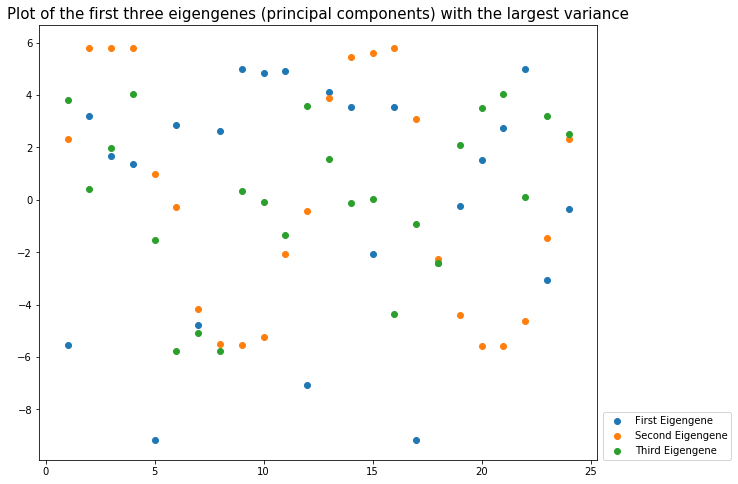

In [18]:
times = np.linspace(1,nc,nc)

eg1 = spca_eigengenes.iloc[:,0]
eg2 = spca_eigengenes.iloc[:,1]
eg3 = spca_eigengenes.iloc[:,2]

plt.figure(figsize=(10,8))
plt.scatter(times, eg1, label="First Eigengene")
plt.scatter(times, eg2, label="Second Eigengene")
plt.scatter(times, eg3, label="Third Eigengene")
plt.title('Plot of the first three eigengenes (principal components) with the largest variance', size=15)
plt.legend(loc=[1.01,0])
plt.show()

Next, plot these three eigengenes against each other:

Text(0.5, 1.0, '2nd vs 3rd')

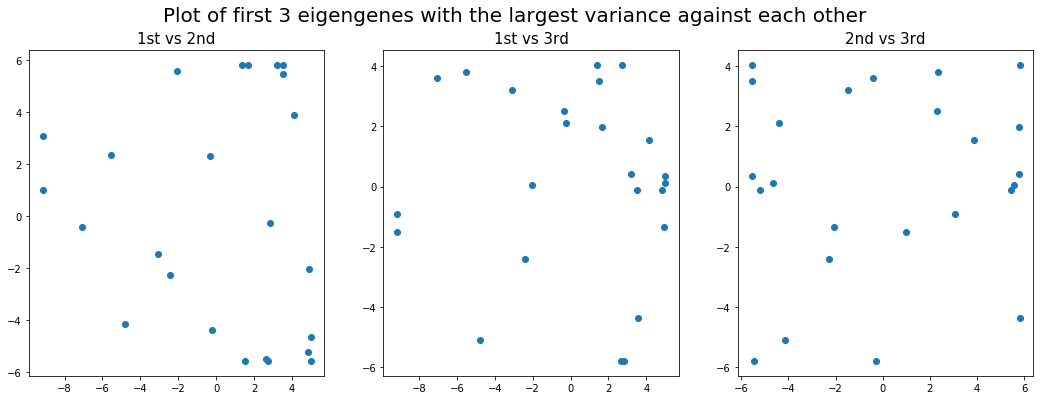

In [19]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,6))
plt.suptitle('Plot of first 3 eigengenes with the largest variance against each other', size=20)

ax1.scatter(eg1, eg2)
ax1.set_title('1st vs 2nd', size=15)
ax2.scatter(eg1, eg3)
ax2.set_title('1st vs 3rd', size=15)
ax3.scatter(eg2, eg3)
ax3.set_title('2nd vs 3rd', size=15)

## 4. Creating the autoencoder model

In [20]:
data = spca_eigengenes.to_numpy()

In [21]:
def jump_control(X):
    X_ = X.copy()
    pop_list = []
    for i in range(1,len(X)):
        if X[i]-X[i-1]<10:
            pop_list.append(i)
    pop_list.sort(reverse=True)
    for i in pop_list:
        X_.pop(i)
    return X_

def iterr(data):
    model = cyclops(data.shape[1])
    n_epochs = 300
    history = model.train(data[np.random.permutation(data.shape[0]), :], epochs=n_epochs, verbose=n_epochs, batch_size=10)

    loss = history.history['loss'][-1]
    
    phase_df = model.phase_output(data)
    phase_idx = phase_df.index.to_numpy()
    phase_list = phase_df.pseudotime.to_numpy()
    
    zipped = list(zip(phase_idx,phase_list))
    re_phase_list = np.array([sorted(zipped, key = lambda t: t[0])[i][1] for i in range(len(zipped))])
    re_phase_idx = np.array([sorted(zipped, key = lambda t: t[0])[i][0] for i in range(len(zipped))])
    
    asc_phase_jump, desc_phase_jump = [],[]
    for i in range(len(re_phase_list)-1):
        if re_phase_list[i+1]-re_phase_list[i] > np.pi:
            desc_phase_jump.append(i)
        elif re_phase_list[i+1]-re_phase_list[i] < -np.pi:
            asc_phase_jump.append(i)
            
    if len(asc_phase_jump) > len(desc_phase_jump):
        phase_jump = asc_phase_jump
    else:
        phase_jump = desc_phase_jump


    phase_jump = jump_control(phase_jump)

    jumps = len(phase_jump)
    for i in range(jumps):
        if len(asc_phase_jump) > len(desc_phase_jump):
            re_phase_list = np.array([re_phase_list[i] if i < phase_jump[0]+1 else re_phase_list[i] + 2*np.pi for i in range(len(zipped))])
        else:
            re_phase_list = np.array([re_phase_list[i] if i < phase_jump[0]+1 else re_phase_list[i] - 2*np.pi for i in range(len(zipped))])
        phase_jump.pop(0)
    
    from scipy.stats import linregress

    lin = linregress(re_phase_idx, re_phase_list)
    
    r_squared = lin[2]**2
    
    return loss, r_squared

In [22]:
%%time

n_iter = 25

iter_list = np.zeros([n_iter,2])

for i in range(n_iter):
    iter_list[i] = iterr(data)

epoch: 300/300, loss: -0.4955, time elapsed:  2.42s, time left:  0.00s
epoch: 300/300, loss: -0.4290, time elapsed:  1.98s, time left:  0.00s
epoch: 300/300, loss: -0.4203, time elapsed:  1.96s, time left:  0.00s
epoch: 300/300, loss: -0.5504, time elapsed:  1.99s, time left:  0.00s
epoch: 300/300, loss: -0.4638, time elapsed:  2.03s, time left:  0.00s
epoch: 300/300, loss: -0.5204, time elapsed:  1.86s, time left:  0.00s
epoch: 300/300, loss: -0.5659, time elapsed:  1.96s, time left:  0.00s
epoch: 300/300, loss: -0.5222, time elapsed:  1.99s, time left:  0.00s
epoch: 300/300, loss: -0.5315, time elapsed:  2.37s, time left:  0.00s
epoch: 300/300, loss: -0.4763, time elapsed:  2.17s, time left:  0.00s
epoch: 300/300, loss: -0.5175, time elapsed:  3.11s, time left:  0.00s
epoch: 300/300, loss: -0.5053, time elapsed:  2.32s, time left:  0.00s
epoch: 300/300, loss: -0.5926, time elapsed:  2.66s, time left:  0.00s
epoch: 300/300, loss: -0.5343, time elapsed:  3.38s, time left:  0.00s
epoch:

In [23]:
cos_sim = np.array([iter_list[i][0] for i in range(len(iter_list))])
r2 = np.array([iter_list[i][1] for i in range(len(iter_list))])

/Users/henrylim/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


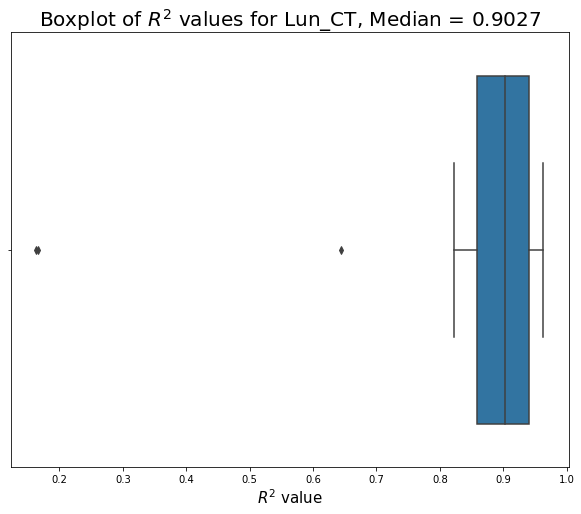

In [24]:
import seaborn as sns
import statistics

plt.figure(figsize=(10,8))
sns.boxplot(r2)
plt.xlabel(r'$R^2$ value', size=15)
plt.title(r'Boxplot of $R^2$ values for {}_CT, Median = {:.4f}'.format(tissue, statistics.median(r2)), size=20)
# plt.savefig('-.png', dpi=300, bbox_inches='tight')
plt.show()